# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [336]:
# загрузки
!pip install lightgbm;

In [337]:
!pip install optuna

In [393]:
!pip install shap

  Using cached shap-0.41.0-cp39-cp39-win_amd64.whl (435 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached numba-0.57.0-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached llvmlite-0.40.0-cp39-cp39-win_amd64.whl (27.7 MB)


In [ ]:
# Импорты
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
import optuna.integration.lightgbm as opt_lgb

from lightgbm import early_stopping

from time import time

import shap

In [339]:
# Константы
RANDOM_STATE = 12345

In [340]:
# Загрузим данные с сервера или локально
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('autos.csv')

## Подготовка данных

In [341]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

👀 Кажется моделей слишком много, проверим

In [343]:
len(data.Model.unique())

251

**Выводы**
- Моделей слишком много
- Модели связаны с брендом отношением - один бренд ко многим моделям
- Именно бренд определяет к какой ценовой нише относится автомобиль
- Модель может быть описана такими характеристиками как тип кузова, мощность и год
- Модель можно исключить из списка признаков для обучения

<div class="alert alert-warning" role="alert">
<b>Комментарий ревьюера:</b>
    
<b>⚠️«Можно лучше»: </b> Комментарии лучше перенести в текстовые ячейки. Комментарии в ячейках кода (#...) нужны для объяснений технических моментов, например, чтобы было понятно как работает функция.

👀 Проверим год выпуска на возможные аномалии

In [344]:
data.RegistrationYear.sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

**Аномальные значения**
- Слишком ранние значения: 1800 и ранее (когда автомобиль еще не изобрели)
- Даты из будущего: 2066 и позднее..

👀 Нельзя продать, чего еще нет - проверим последнюю дату создания объявления

In [347]:
data.DateCreated.sort_values(ascending=False).iloc[0]

'2016-04-07 00:00:00'

<div id=1></div>

**Аномальные значения**
- Год и месяц регистрации после 2016-04-07

👀 Изучим распределение записей по мощности двигателя

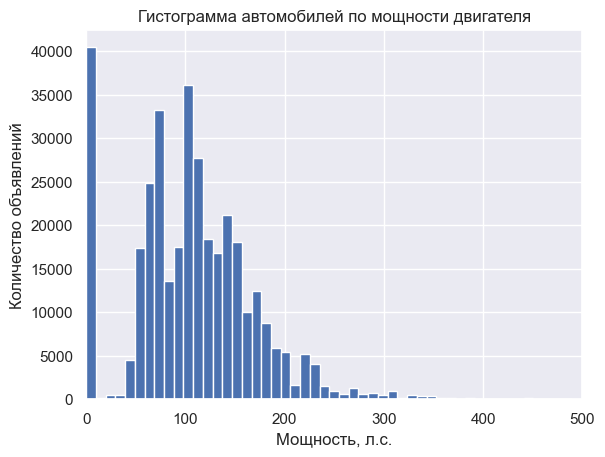

In [348]:
data[data.Power < 500].Power.plot(kind='hist', bins=50, xlim=(0, 500),
                                  title="Гистограмма автомобилей по мощности двигателя")
plt.xlabel("Мощность, л.с.")
plt.ylabel( "Количество объявлений");

**Аномальные значения**
- 40_000 объявлений с мощностью автомобиля меньше 10 л.ч

👀 Изучим распределение записей по цене в диапазоне от 0 до 200

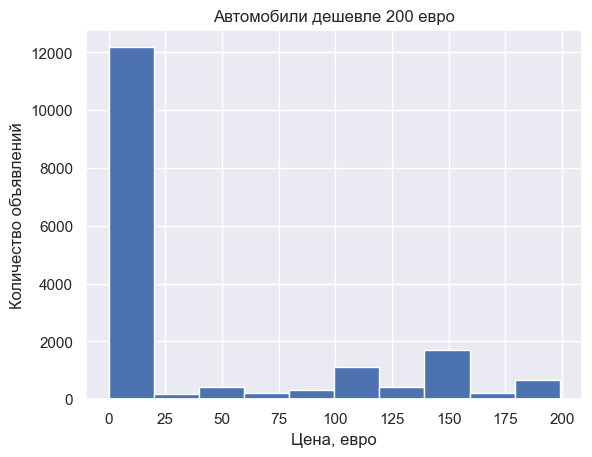

In [349]:
data[data.Price < 200].Price.plot(kind='hist', bins=10)
plt.title("Автомобили дешевле 200 евро")
plt.xlabel("Цена, евро")
plt.ylabel( "Количество объявлений");

**Аномальные значения**
- 12_000 объявлений с ценой меньше 20 евро

👀 Изучим распределение записей по пробегу

👀 Изучим распределение записей по пробегу

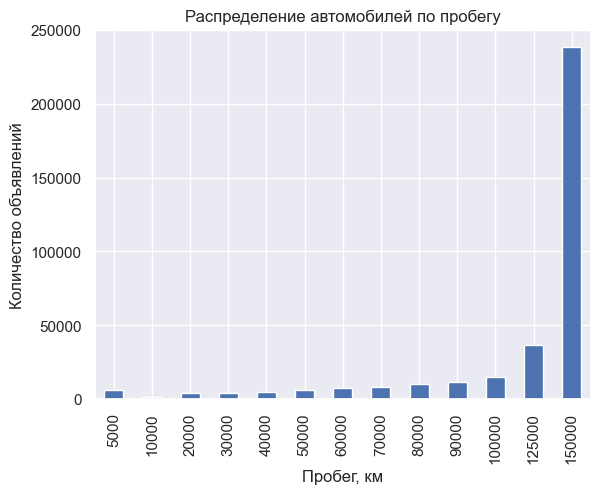

In [350]:
(data.Kilometer
 .value_counts()
 .sort_index()
 .plot(kind='bar'))
plt.xticks(rotation='vertical')
plt.title("Распределение автомобилей по пробегу")
plt.xlabel("Пробег, км")
plt.ylabel( "Количество объявлений");

**Выводы**
- Значения пробега дискретны, что скорее всего связано с формой сбора данных.
- Значения 150 000 км - аномально большое. Скорее всего туда отнесены автомобили с пробегом 150 000 ки и выше
- Возможно стоит разделить на 2 категории с пробегом
 - меньше 150 000 км
 - 150 000 км и больше

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Не стал делить на 2 категории. Возможно, что часть информации при таком агрегировании будет потеряна.
</div>  

👀 Изучим распределение записей по количеству фотографий

In [351]:
data.NumberOfPictures.value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

**Выводы**
- Объявлений с фотографиями нет
- Столбей не информативен

**Результаты анализа данных**
___
`Не нужны` следующие данные:
- `PostalCode` — почтовый индекс владельца анкеты (пользователя). Индекс может даже не совпадать с регионом продажи авто.
- `NumberOfPictures` — фотографий нет - столбец не информативен
- Все данные с датами по статусу объявления (не касается авто)
 - `LastSeen` — дата последней активности пользователя 
 - `DateCrawled` — дата скачивания анкеты из базы
 - `DateCreated` — дата создания анкеты  (если бы была дата продажи, то возможно был бы смысл)
- `Model` — модель автомобиля (251 модель слишком много для кодирования, большинство моделей мало представлены, у 5% объявлений данные отсутствуют)
- `RegistrationMonth` — месяц регистрации автомобиля (чтобы избежать чрезмерной дискретности учета возраста автомобиля)
___
- Что следует `преобразовать`:
 - Заполнить пропуски в столбцах `Gearbox`, `FuelType`, `VehicleType`, `Repaired` значением `no_info`
 - Удалить записи с аномальными значениями
  - `RegistrationYear` — год регистрации автомобиля (до 1910 или после 2016)
  - `Price` — цена меньше 100 (после 100 возможна продажа авто после ремонта)
  - `Power` — мощность (меньше 10 и больше 500)

- Удалим ненужные признаки

In [352]:
data.drop(['PostalCode', 'LastSeen', 'NumberOfPictures', 'Model',
           'DateCrawled', 'DateCreated', 'RegistrationMonth'], axis=1, inplace=True)

- Оценим количество отсутствующих значений

In [353]:
data.isna().mean()[data.isna().sum() > 0]

VehicleType    0.105794
Gearbox        0.055967
FuelType       0.092827
Repaired       0.200791
dtype: float64

- Заменим отсутствующие значения на 'no_info'

In [354]:
data.fillna('no_info', inplace=True)

- Удалим аномалии по возрасту, цене и мощности

In [355]:
data.drop(data.query('RegistrationYear < 1910 or ' +
                     'RegistrationYear > 2016 or ' +
                     'Price < 100 or ' +
                     'Power < 10 or ' +
                     'Power > 500').index, inplace=True)

- Разделим данные на целевое значение и признаки

In [356]:
target = data.Price
features = data.drop('Price', axis=1)

<div id="3"></div>
👀 Изучим взаимную корреляцию признаков

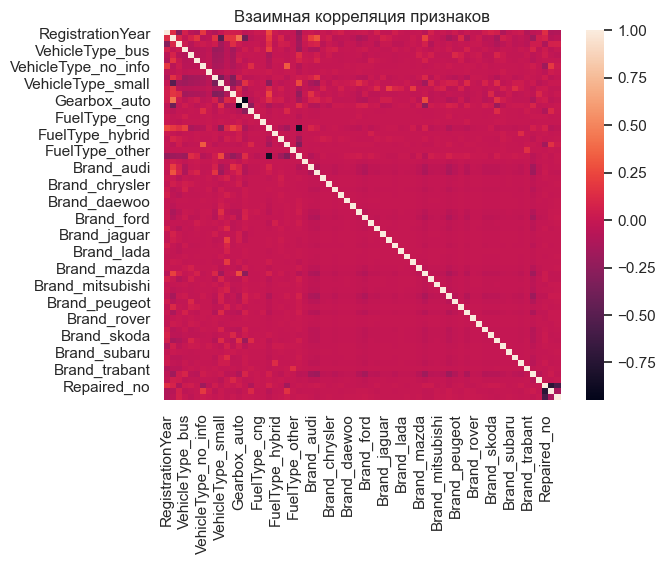

In [357]:
sns.heatmap(pd.get_dummies(features).corr())
plt.title("Взаимная корреляция признаков");

- Взаимной корреляции признаков не выявлено

In [358]:
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

- Разделим данные на обучающую и проверочную выборки

In [359]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, test_size=.2,
                                                random_state=RANDOM_STATE)

<div id="4"></div>


- Настроим экземпляр класса OrdinalEncoder
 - *подготовка категориальных признаков для деревьев решений*

In [360]:
ordinal_encoder_params = [('category_encoder',
                             OrdinalEncoder(dtype=int,
                                            handle_unknown='use_encoded_value',
                                            unknown_value=-1),
                             categorical_features)]
ordinal_encoder = ColumnTransformer(ordinal_encoder_params, remainder='passthrough')

<div id="2"></div>

- Настроим экземпляр класса OneHotEncoder
 - *подготовка категориальных признаков для линейных моделей*

In [361]:
ohe_params = [('scaler', StandardScaler(), ['RegistrationYear', 'Power', 'Kilometer']),
                    ('ohe_to_specified',
                     OneHotEncoder(dtype=int, sparse_output=False, handle_unknown='ignore'),
                     categorical_features)]
one_hot_encoder = ColumnTransformer(ohe_params, remainder='passthrough')

- Подготовим метрику (RMSE) для подбора оптимальных параметров моделей sklearn с кросс-валидацией

In [362]:
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

<div id="5"></div>

- Создадим функцию для сбора времени выполнения и лучшей метрики модели

In [363]:
summary = []

In [364]:
def model_performance(func, *args, model=None, step=0, summary=summary, **kwargs):
    """Квази-декоратор оценки качества модели."""
    steps = {0: "обучение", 1: "предсказание"}
    start = time()
    x = func(*args)
    period = round(time() - start, 1)
    best_score = 0
    if not step:
        try:
            best_score = round(abs(x.best_score_), 1)
        except AttributeError:
            best_score = round(abs(func.__self__.best_score), 1)
    summary.append((model, steps[step], period, best_score))
    print(f'Модель: {model}. Этап: {steps[step]}.')
    print(f"Операция заняла {period:.1f} секунд.")
    print(f'Значение RMSE: {best_score:.1f}')
    return 

**Подготовка данных**
___

- Удалили ненужные признаки

- Заменили отсутствующие значения на 'no_info'

- Удалили аномалии по возрасту, цене и мощности

- Разделили данные на обучающую и проверочную выборки

- Настроили экземпляр класса OrdinalEncoder
 - *подготовка категориальных признаков для деревьев решений*

- Настроили экземпляр класса OneHotEncoder
 - *подготовка категориальных признаков для линейных моделей*

- Подготовили метрику (RMSE) для подбора оптимальных параметров моделей sklearn с кросс-валидацией

- Создадили функцию для сбора времени выполнения и лучшей метрики модели

## Обучение моделей

###  LightGBM

- Подготовим данные для модели (категориальные данные трансформируем с помощью OrdinalEncoder)

In [365]:
cv_data = opt_lgb.Dataset(data=ordinal_encoder.fit_transform(Xtrain), label=ytrain)

- Настроим параметры регрессии с метрикой RMSE

In [366]:
param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",    
}

- Настроим модель градиентного бустинга с кросс-валидацией
 - интеграция LightGBM и Optuna

In [367]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [368]:
opt_lgb_cv = opt_lgb.LightGBMTunerCV(
    param,
    cv_data,
    nfold=4, stratified=False,
    callbacks=[early_stopping(1, verbose=False)],
    optuna_seed=RANDOM_STATE,
    time_budget=300,
    show_progress_bar=True,
    return_cvbooster=True
)

In [369]:
model_performance(opt_lgb_cv.run, model='Optuna LightGBM', summary=summary)

  0%|          | 0/5 [00:00<?, ?it/s]

Модель: Optuna LightGBM. Этап: обучение.
Операция заняла 328.8 секунд.
Значение RMSE: 1551.0


In [370]:
model_performance(opt_lgb_cv.get_best_booster().predict,
                  ordinal_encoder.fit_transform(Xtrain),
                  model='Optuna LightGBM', step=1, summary=summary)

Модель: Optuna LightGBM. Этап: предсказание.
Операция заняла 21.6 секунд.
Значение RMSE: 0.0


### Другие модели

#### Лассо

- Будем настраивать сновной параметр Лассо - коэффициент штрафов

In [371]:
lasso_params = {
    'lasso__alpha': list(10 ** degree for degree in range(-2, 4)),
    }

- Создадим конвейер: преобразование категориальных признаков (OHE) -> Lasso

In [372]:
lasso_pipe = Pipeline([
    ('transformer', one_hot_encoder),
    ('lasso', Lasso(precompute=True, tol=.001, random_state=RANDOM_STATE)), 
]);

- Создадим оцениватель с последовательным перебором параметров

In [373]:
lasso_gs = GridSearchCV(lasso_pipe, lasso_params, cv=4, scoring=scorer, n_jobs=-1)

In [374]:
lasso_func = {
    'обучение': lasso_gs.fit,
    'предсказание': lasso_gs.predict
}

In [375]:
model_performance(lasso_gs.fit, Xtrain, ytrain, model="Лассо", summary=summary)

Модель: Лассо. Этап: обучение.
Операция заняла 45.5 секунд.
Значение RMSE: 2738.7


C:\Users\PAVILION\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431989673728.1522, tolerance: 5008949050.772013
  model = cd_fast.enet_coordinate_descent_gram(


In [376]:
model_performance(lasso_gs.predict, Xtrain, model="Лассо", step=1, summary=summary)

Модель: Лассо. Этап: предсказание.
Операция заняла 1.4 секунд.
Значение RMSE: 0.0


#### Случайный лес

In [377]:
# основные параметры Случайного Леса - количество деревьев и максимальная глубина
rf_params = {
    'random_forest__n_estimators': [70, 80],
    'random_forest__max_depth': [11, 13, 15]
}

In [378]:
rf_pipe = Pipeline([
    ('transformer', ordinal_encoder),
    ('random_forest', RandomForestRegressor(random_state=RANDOM_STATE))
]);

In [379]:
# создание оценивателя со случайным перебором наборов параметров
rf_gs = GridSearchCV(rf_pipe, rf_params, cv=4, scoring=scorer)

In [380]:
model_performance(rf_gs.fit, Xtrain, ytrain, model="Случайный Лес", summary=summary)

Модель: Случайный Лес. Этап: обучение.
Операция заняла 1040.5 секунд.
Значение RMSE: 1643.0


In [381]:
model_performance(rf_gs.predict, Xtrain, model="Случайный Лес", step=1, summary=summary)

Модель: Случайный Лес. Этап: предсказание.
Операция заняла 5.5 секунд.
Значение RMSE: 0.0


**Обучение моделей**
___
- Для обучения и оценки были выбраны следующие модели
 - Градиентный бустинг - LightGBM
 - Линейная регрессия с регуляризацией L1 - Lasso
 - Ансамбль решающих деревьев - RandomForestRegressor
- Модели обучались с кросс-валидацией и автоматическим подбором параметров с использованием
 - Optuna - для градиентного бустинга
 - PipeLine и GridSearchCV - для Лассо и Случайного леса
- Данные по достигнутому значению метрики качества и времени на обучение и прогноз собирались в список

## Анализ моделей

In [382]:
def time_spent(func):
    """Декоратор оценки вермени выполнения функции."""
    def wrapper(*args):
        start = time()
        func(*args)
        print(f"Предсказание заняло {time() - start:.1f} секунд.")
    return wrapper
        
@time_spent
def predictions_info(model_fitted, model_name, Xtest, ytest):
    """Оценка среднеквадратической ошибки предсказания."""
    ypred = model_fitted.predict(Xtest)
    if isinstance(ypred, list):
        ypred = sum(i for i in ypred) / len(ypred)
    score = mean_squared_error(ytest, ypred, squared=False)
    print(f"Модель: {model_name}")
    print(f"Среднеквадратичная ошибка предсказания: {score:.1f}")

In [383]:
pd.DataFrame(summary, columns=["Модель", "Этап", "Время", "RMSE"]).set_index(["Модель", "Этап"])

Время    RMSE
Модель          Этап                        
Optuna LightGBM обучение       328.8  1551.0
                предсказание    21.6     0.0
Лассо           обучение        45.5  2738.7
                предсказание     1.4     0.0
Случайный Лес   обучение      1040.5  1643.0
                предсказание     5.5     0.0

In [384]:
# получим оцениватель градиентного бустинга с минимальным значением ошибки
bst = opt_lgb_cv.get_best_booster()
predictions_info(bst, "Градиентный бустинг",
                 ordinal_encoder.fit_transform(Xtest), ytest)

Модель: Градиентный бустинг
Среднеквадратичная ошибка предсказания: 1549.5
Предсказание заняло 5.6 секунд.


**Выводы**
___
- В ходе анализа моделей регрессии были изучены три вида `градиентный бустинг LightGBM`, 
`Лассо` и `случайный лес`.
- Критерии оценки: скорость обучения, скорость предсказания и минимизация ошибки.
- `Худший` результат на наших данных показала модель `Лассо`. При самой быстрой скорости обучения (`45.5 с`) и предсказания (`0.1 с`), она показала наибольшую `ошибку` `2738.7` (по условию задания - не выше 2500).
- `Случайный лес` показал приемлемое значение `ошибки` (`1643`), но при этом оказался `самым долго обучаемым` (`1040.5 c`). Обученная модель работает быстро (`5.5 с`)
- `Градиентный бустинг` показал `минимальную ошибку` (`1551`) среди всех моделей и премлемую скорость `обучения` (`328.8 c`) и скорость `предсказания` (`21.6 с`).
- На тесте `Градиентный бустинг` показал `ошибку` (`1549,5`) и скорость `предсказания` (`5.6 с`). Минимальное расхождение в ошибке между валидационными и тестовыми данными говорит о том, что модель правильно обучена. Данная модель `рекомендуется` Заказчику.